# Direct spectrum estimation of speech signal

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/obama.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency
stepsize=10

# inference and modelling
AR_order = 20                            # order of auto-regressive model
iterations = 5                           # number of iterations for variational message passing
Œõ_meas = 1e4*Ic(stepsize)                            # assumed precision of measurement noise

# save file
savefile = "inferred_values/speech2_AR"*string(AR_order, pad=2)*".h5"
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[20*fs_time+1:23*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCnCOW8wa2AvsC2BL3R5W49mfDVvQbAob3dP4e+AVH2vZZYaTxgBAu9CZfmPO4m7r2QBDm9BUgRPnOnYD39fSg9Hupave+yprw3dLc9gd8iO8F+a72y35i8LSgMPVvOYj7uO+090rUIvgCzSz2afRQ++WxGPrrIGj1J1Eu+9WEVuUv/8byzSAW+6pLavQzAgr6Zld69M4guvLO5YDyyPbc9vyLQvVZskb22nLU9To6SPSU4nD2pd/K80HVUvQV9PT1KJw+77lO2vJXQHjwySjw91LlDPuzn5D3ewZC96/jQPRb28z2IKRg+sQo9PPjLMb69Iqk8MbJ2vVxQBr7YjHW9ky89vosUib3ef5e8TDHqvMTAhT1I0gm+bZyNvTqlpD29lLo993ANPugwkzpQky+9kbk0PONVQb0dyg29CQAFPdA5xD19Zlc+bTqgPVKLlr2cW8M9Wh3BPSHxAT5yHeS8CHMivlG+zTyig6a9a5H9vfVFsr0tPia+cjssvb6YaL3OlBe9liEWPNLv672fF128mGPTPUGU3T1Pc+A9K704vQ9nZb2cfFC80s6hvBocqDo6DLA9ySEFPhfoLD7xhFw9Wuyxva3Gzj1YuPE99XX3PS/h5rx21SO+T8b2PPrmu71tB769oLSZvSXvK75Jv0+9fDezvXHwQr2aM/E7gOvYvXEy1TmvRMM9oG2LPdwMMz1+/KO9QbElvahdhzxjlqY8kOdePaSQWT2hZQM+GUwQPsSClD05cLC83a3EPZ02DD6d9pQ9Zy0cvbg/Ib70j4y8AUR3vX6WjL1+GRG9SOIIvleTo7047b+9Ey4ivWqKA7uXB+K9Kv/QvNqORz2Mmn09r/fTPDzrg70iAXe8o66WPKc8CD09HZk9ZDL7PFWvyD0nj/I902iUPeOIDT0evGQ9gRaiPaJ4Az0QwRa9bPlmvQZhKrsMUFs8kNaNvPl0Kr0M43S96uCzvYe2xL0p36C6ruyxPMZzhL1d1FW90X4mvW3NFbvGaia8p1ZKvZwLebs8Dp27xPmtPGY2Hj0SPQe8jJ5gPGDY9zy2rAY985yhPK5DTrwq6Aw9ROxhPURgFT1Ca089jAY3PfMC3Tz6ep08LQA6vCbX0jrCh7a6njyduTnO1DwPfwC7y2J0va8ulL0PPrO9fApnvWsEorz5nia9cK7wvNduxrwO1tq8CyfsvFoi6bwcWqW8tfnbvH+Vqrwnzkc79SqSPOgg1DyUcyU9zJ6JPbB5Ej2U1T09yeVVPQ6HQz2R7WA9UvxRPRlKNj0QlDw9vDm7O+4ay7x7phe9pB1yvbG8Kb2i4JO8m3M5vOTBl7zkEym9Ly1VvYyRtLzNz3u8jzyqu4iKDbz8Ca682czavPI9PL3Y7i29b8wfuzZUCzsqo+k40GutPFzjpjwDRFk9va52PWKJmj0CnZg9zqBiPUVi5DxIldo8K8jzO5LReLtKiIg74SUlPPo6BrsIOKG8tSbovAXfCb2GUhS9VNUAvUJolbwkDI+89bobvcMDQL1Ljsu8EMAmvLiGprtBTd68VBQAvSyYW72bbTq9BDQfvNxkojwNWh49Qo9fPU7fVz1lBUE9Sh4ZPb+OpzzBfug8WGsYPZKUsDyfdBY9dGbjPIJaiTx7puE8LbF5vJ9ClLuUIrC80XGBvXgNLb1XuTe9Kr0VvcPTHjwC9cE70A65vNbbKL3LkTm9eKYDvdey+byWaFm82UYxu2L0lby7Zqg6w2FuOkTWrLoqiaQ8Y0JSPKjgbT3RW6I9Dvx0PQcPNz2WcGg8DEkevKyeEjyzYqI8bkNZPItixjt76kO8P4CWvA8727neH2K8ZqkkvB3M4LycNzS9mRNcvBnuEbvM83888EU6PNhZ/Ly1pVa9MtdXvYfrer0vYRG96Iozu6SKkTyowl49LBQ6PUQZPT1JHxs962vnPLbOOj0JGQs9TNsSPXcrAj2pnUs74OAcPETD3Lstto+89PT3u74zObwelTO8rzLZO6H3qruRRZa8vPrYvH+fIr0yQku9j8hNvVLrH71yTYa9kkaJvbQVO73SsM+8KnXZuZQVgbov2go7b/mkPKc0MTwSBQY9soGAPQpNUz3O+G092EhSPa/MHD3FjBc9XVuWPJ6rATw5D9Y7bP01vCkkkTs5Vr67cAAiPEM/7jxtgTk7Lw9xvPCoJr3tTHO9tOMjvZ7qNL1f/l69c1bhvAvvGL0OGd28vRocvCVfJ7wOp3m8/9YNvLWaV7wVUoU8jrOJPO06DT3u+1A9a4FtPQGypz2xXV89ufICPXgbMj0tXSs9dAVFPcny9Dz7c8O7W3SyvOw5Cr18Xsq8GO6buylumbvzv8i8da8ZvDol4rx/KU68WkEAverFhr0dbKC9O6Wevbezi735Rka9wK4Rvd2fb7zyMJC75hrgO3DlrjzXIFI8jjzNPIziVj0qSoo9E62ePc41kz0aolw9eCD1PAgrebs8NgW8onu/vOPICb2OWvm8HNrBuzOOITynq648f1wou7oX4btw7eW8BWsuvfxYg73EGrO9RVixvaNqqL2ik5G9Znc5vTK8+ryBJ2O8l4LXup3bJDx+ki09/I+PPRnMwT2DH8U9Qv+VPSxJWT2SKU898iCbPHz7Ej2z6cM8teByPHX6uTx48z88TcYtPDtXOTwZGkW853urOueCn7yq5E+9hpc7vXKLnL16m269it4lvQBKE73qnNa8oyI6vU3AGL3pC228L5NFPBAJUj3FVx49289APZI/bz28cWY9antnPeUHjD33DIc9nat/PYh/Xz10Rg09+5wOPZL2pTwQY0M8RAeTPETxWDxAT4u60DDKvPlVR704xBi91fhUvbA7W72ef1K9DDOSvYutW73uF/i8x3ubvD1Cbjz7xC48/s43PDicqLzkfBy9bThKvKmhkDlrKWA9ZNGKPdg7lD1Yh5o9b5CYPXh9pj3kJaI9KdRTPUegVD2RmYY8XfE/uw2Am7tAePi6g/EKuo4y0rz4foS9k1mUvUnttr1k3Yy9zdE8vYZpQr2JU6K8MUwHvTtwHL0+uRO9tHdFvaKgeb3zBhq9D4cnvVCsr7wHpKC83ZmNu5d0HT1wD2E9Jz1oPbMwhD3j1Fg9Ze8XPYjF6DxHbIm8kbqqOyEIt7tdDBe9SBcWvWoImr1Hlye96JQDvbf48bx4wS68Yx4HvUPrSbzyE9y8YbRBvZXpQL1BDDy9bIMlvWmnRLyG8IO8tqmavDEYbLzdM4G8jkMrPZHYiDyisT897XKAPJqdPj220II9x4M4PULRHD2b+gE5uUqZvPXX2jl0xdi8pZd9vBmjm7zCueK8DWJXu+tWN7llOdu8UftqvddGgr3J0Xm9HDCFvDN5Ir2omTi988wKvaf8jb21sga8iJoCvZaMIjzieoQ8fEUjPSaCnT3lODc99qaoPYfOVD2cLS89nFxZPWsgODuAGeo8tNlKvA3YCD0YjZw9nDIJPRWLPT3DWzq9/sNxvMaVOr2aW5K8ElMAvJ1rA72IYDS7PMocvRW9ZbxkgDi9+NA1vQe/WLwjC/i8ovIIvHJuHL2qh1k9PokvPQqU9D182qw9TQOzPaAVabvOdom8eo7RPUjUWj3wO989g+kiuuAoKzzI55k9XsOjvCgQKT08i1K8xi0wvVELgrtSlj+91IYGu4haaL1gy4q92NHgvN1ovLzaNk29r1iWvD53Qb2NhiO9z0IoOykD+Dx0WIU9wNeSPXmrnj1iWsc9mKhtPZmxjbzLVxI+vwnRPbCiAT4FRYY87CC+vetVjD3aOou9nqoFvYGwSL0Syw++9X9EvYxdgb15DAK96fMBvZAbBr596kC9dji9OlQIA71U2Ac8Qti1vO3cTTsUajQ9jkO/PC/MXj0uh

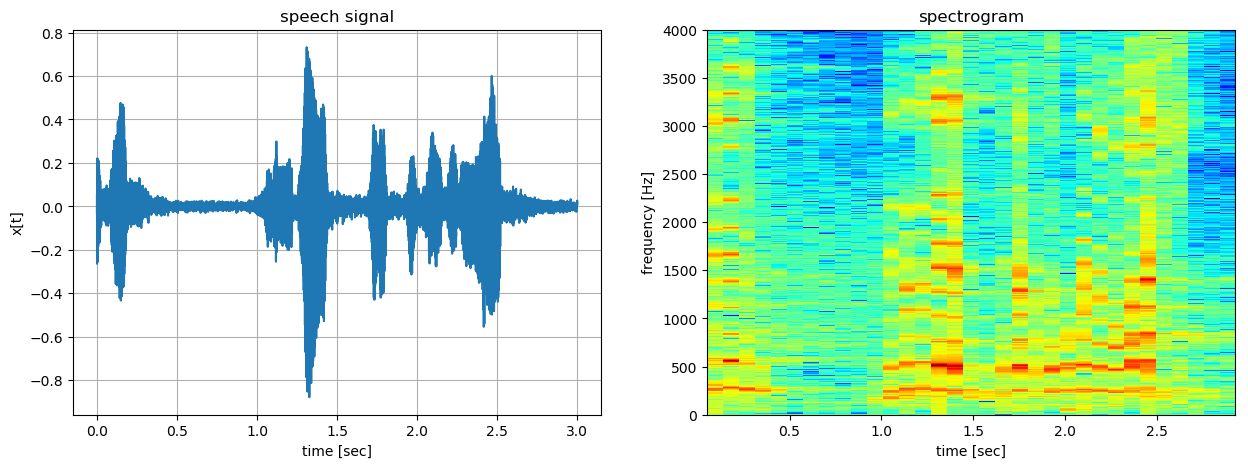

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [5]:
# create factor graphs
fg = FactorGraph()
S = Vector{Variable}(undef, stepsize)

# AR node
@RV Œ≥ ~ ForneyLab.Gamma(placeholder(:a_Œ≥), placeholder(:b_Œ≥))
@RV Œ∏ ~ GaussianMeanPrecision(placeholder(:Œº_Œ∏, dims=(AR_order,)), placeholder(:Œõ_Œ∏, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:Œº_Sprev, dims=(AR_order,)), placeholder(:Œõ_Sprev, dims=(AR_order, AR_order)))
Smin = Sprev
for s = 1:stepsize
    @RV S[s] ~ LAR.Autoregressive(Œ∏, Smin, Œ≥)
    Smin = S[s]
end

# selection and input
d = zeros(stepsize, AR_order)
for s in 1:stepsize
    d[s,s] = 1
end
@RV x = d*Smin
@RV y ~ GaussianMeanPrecision(x, Œõ_meas)
placeholder(y, :y, dims=(stepsize,))

ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15898257015425572947 -->
 15898257015425572947 
 
 ùí© 
 gaussianmeanprecision_3 
 
<!-- 11979192118856016047 -->
 11979192118856016047 
 
 √ó 
 multiplication_1 
 
<!-- 15898257015425572947--11979192118856016047 -->
 15898257015425572947--11979192118856016047 
 
 x 
 1 out 
 2 m 
 
<!-- 14208366895765375802 -->
 14208366895765375802 
 
 clamp_2 
 
<!-- 15898257015425572947--14208366895765375802 -->
 15898257015425572947--14208366895765375802 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 17470306015853098218 -->
 17470306015853098218 
 
 placeholder_Œº_Sprev 
 
<!-- 5445589428567930799 -->
 5445589428567930799 
 
 placeholder_Œº_Œ∏ 
 
<!-- 3288064480597650172 -->
 3288064480597650172 
 
 = 
 equ_Œ≥_1 
 
<!-- 7201932720292230330 -->
 7201932720292230330 
 
 AR 
 autoregressive_2 
 
<!-- 3288064480597650172--7201932720292230330 -->
 3288064480597650172--7201932720292230330 
 
 Œ≥ 
 4 Œ≥ 
 3 3 
 
<!-- 6137054544359878960 -->
 6137054544359878960 
 
 AR 
 autoregressive_1 
 
<!-- 3288064480597650172--6137054544359878960 -->
 3288064480597650172--6137054544359878960 
 
 Œ≥ 
 4 Œ≥ 
 2 2 
 
<!-- 18107259205421642776 -->
 18107259205421642776 
 
 Gam 
 gamma_1 
 
<!-- 3288064480597650172--18107259205421642776 -->
 3288064480597650172--18107259205421642776 
 
 Œ≥ 
 1 out 
 1 1 
 
<!-- 7201932720292230330--6137054544359878960 -->
 7201932720292230330--6137054544359878960 
 
 S_1 
 1 y 
 2 x 
 
<!-- 1941970505477763315 -->
 1941970505477763315 
 
 = 
 equ_Œ∏_1 
 
<!-- 1941970505477763315--7201932720292230330 -->
 1941970505477763315--7201932720292230330 
 
 Œ∏ 
 3 Œ∏ 
 3 3 
 
<!-- 1941970505477763315--6137054544359878960 -->
 1941970505477763315--6137054544359878960 
 
 Œ∏ 
 3 Œ∏ 
 2 2 
 
<!-- 11148069195524045855 -->
 11148069195524045855 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 1941970505477763315--11148069195524045855 -->
 1941970505477763315--11148069195524045855 
 
 Œ∏ 
 1 out 
 1 1 
 
<!-- 339489157776810403 -->
 339489157776810403 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 6137054544359878960--339489157776810403 -->
 6137054544359878960--339489157776810403 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 6291164750919408792 -->
 6291164750919408792 
 
 placeholder_Œõ_Sprev 
 
<!-- 11979192118856016047--7201932720292230330 -->
 11979192118856016047--7201932720292230330 
 
 S_2 
 1 y 
 2 in1 
 
<!-- 11396991311646811861 -->
 11396991311646811861 
 
 clamp_1 
 
<!-- 11979192118856016047--11396991311646811861 -->
 11979192118856016047--11396991311646811861 
 
 clamp_1 
 1 out 
 3 a 
 
<!-- 12908956805886392970 -->
 12908956805886392970 
 
 placeholder_Œõ_Œ∏ 
 
<!-- 339489157776810403--17470306015853098218 -->
 339489157776810403--17470306015853098218 
 
 Œº_Sprev 
 1 out 
 2 m 
 
<!-- 339489157776810403--6291164750919408792 -->
 339489157776810403--6291164750919408792 
 
 Œõ_Sprev 
 1 out 
 3 w 
 
<!-- 8389109907648326547 -->
 8389109907648326547 
 
 placeholder_b_Œ≥ 
 
<!-- 18107259205421642776--8389109907648326547 -->
 18107259205421642776--8389109907648326547 
 
 b_Œ≥ 
 1 out 
 3 b 
 
<!-- 8129824918026106861 -->
 8129824918026106861 
 
 placeholder_a_Œ≥ 
 
<!-- 18107259205421642776--8129824918026106861 -->
 18107259205421642776--8129824918026106861 
 
 a_Œ≥ 
 1 out 
 2 a 
 
<!-- 11148069195524045855--5445589428567930799 -->
 11148069195524045855--5445589428567930799 
 
 Œº_Œ∏ 
 1 out 
 2 m 
 
<!-- 11148069195524045855--12908956805886392970 -->
 11148069195524045855--12908956805886392970 
 
 Œõ_Œ∏ 
 1 out 
 3 w 
 
<!-- 14845638054492018298 -->
 14845638054492018298 
 
 plac

## Algorithm generation

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏, [S..., Sprev], Œ≥, ids=[:Œ∏ :S :Œ≥])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepŒ≥!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_1_Sprev], marginals[:Œ∏], nothing)
messages[3] = ruleSVariationalARIn3PPPN(marginals[:S_2_S_1], marginals[:Œ∏], nothing)
messages[4] = ruleSPEqualityGammaWishart(nothing, messages[2], messages[3])

marginals[:Œ≥] = messages[1].dist * messages[4].dist

return marginals

end

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 8))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:Œº_Sprev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Œõ_Sprev]))
messages[2] = ruleSVariationalAROutNPPP(nothing, messages[1], margi

## Perform inference

In [7]:
# create memory variables
Œº_Œ∏_mem = Array{Array{Float64, 1}}(undef, length(x_time))
Œõ_Œ∏_mem = Array{Array{Float64, 2}}(undef, length(x_time))
a_Œ≥_mem = Array{Float64}(undef, length(x_time))
b_Œ≥_mem = Array{Float64}(undef, length(x_time))
Œº_x_pred = Array{Array{Float64, 1}}(undef, length(x_time))
var_x_pred = Array{Array{Float64, 2}}(undef, length(x_time))

# set priors
Œº_Œ∏_min = randn(AR_order)
Œõ_Œ∏_min = 1e-4 * Ic(AR_order)
Œº_S_min = zeros(AR_order)
Œõ_S_min = 1e4 * Ic(AR_order)
a_Œ≥_min = 1
b_Œ≥_min = 0.001

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:Œ∏ => vague(GaussianMeanPrecision, AR_order),
                 :Œ≥ => vague(Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order))

# create messages array 
messages= Array{Message}(undef, 12)

# loop through samples
for k = 1:stepsize:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => reverse(x_time[k:k+stepsize-1]),
                :Œº_Œ∏ => Œº_Œ∏_min,
                :Œõ_Œ∏ => Œõ_Œ∏_min,
                :a_Œ≥ => a_Œ≥_min,
                :b_Œ≥ => b_Œ≥_min,
                :Œº_Sprev => Œº_S_min,
                :Œõ_Sprev => Œõ_S_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    Œº_x_pred[k] = ForneyLab.unsafeMean(messages[4].dist)
    var_x_pred[k] = ForneyLab.unsafeCov(messages[4].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepŒ≥!(data, marginals)
        stepŒ∏!(data, marginals)
    end
    
    # update priors
    Œº_Œ∏_min = ForneyLab.unsafeMean(marginals[:Œ∏])
    Œõ_Œ∏_min = ForneyLab.unsafePrecision(marginals[:Œ∏])
    Œº_S_min = ForneyLab.unsafeMean(marginals[:S_*Symbol(stepsize)])
    Œõ_S_min = ForneyLab.unsafePrecision(marginals[:S_*Symbol(stepsize)])
    a_Œ≥_min = marginals[:Œ≥].params[:a]
    b_Œ≥_min = marginals[:Œ≥].params[:b]
    
    # save infered parameters
    Œº_Œ∏_mem[k] = Œº_Œ∏_min
    Œõ_Œ∏_mem[k] = Œõ_Œ∏_min
    a_Œ≥_mem[k] = a_Œ≥_min
    b_Œ≥_mem[k] = b_Œ≥_min
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|  ETA: 0:00:01m

## Predictions

In [16]:
if typeof(Œº_x_pred) == Array{Array{Float64,1},1}
    Œº_x_pred = expand(Œº_x_pred[1:stepsize:end])
    var_x_pred = expand([[var_x_pred[i][k,k] for k = 1:stepsize] for i = 1:stepsize:length(x_time)] )
end
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCnCOW8wa2AvsC2BL3R5W49mfDVvQbAob3dP4e+AVH2vZZYaTxgBAu9CZfmPO4m7r2QBDm9BUgRPnOnYD39fSg9Hupave+yprw3dLc9gd8iO8F+a72y35i8LSgMPVvOYj7uO+090rUIvgCzSz2afRQ++WxGPrrIGj1J1Eu+9WEVuUv/8byzSAW+6pLavQzAgr6Zld69M4guvLO5YDyyPbc9vyLQvVZskb22nLU9To6SPSU4nD2pd/K80HVUvQV9PT1KJw+77lO2vJXQHjwySjw91LlDPuzn5D3ewZC96/jQPRb28z2IKRg+sQo9PPjLMb69Iqk8MbJ2vVxQBr7YjHW9ky89vosUib3ef5e8TDHqvMTAhT1I0gm+bZyNvTqlpD29lLo993ANPugwkzpQky+9kbk0PONVQb0dyg29CQAFPdA5xD19Zlc+bTqgPVKLlr2cW8M9Wh3BPSHxAT5yHeS8CHMivlG+zTyig6a9a5H9vfVFsr0tPia+cjssvb6YaL3OlBe9liEWPNLv672fF128mGPTPUGU3T1Pc+A9K704vQ9nZb2cfFC80s6hvBocqDo6DLA9ySEFPhfoLD7xhFw9Wuyxva3Gzj1YuPE99XX3PS/h5rx21SO+T8b2PPrmu71tB769oLSZvSXvK75Jv0+9fDezvXHwQr2aM/E7gOvYvXEy1TmvRMM9oG2LPdwMMz1+/KO9QbElvahdhzxjlqY8kOdePaSQWT2hZQM+GUwQPsSClD05cLC83a3EPZ02DD6d9pQ9Zy0cvbg/Ib70j4y8AUR3vX6WjL1+GRG9SOIIvleTo7047b+9Ey4ivWqKA7uXB+K9Kv/QvNqORz2Mmn09r/fTPDzrg70iAXe8o66WPKc8CD09HZk9ZDL7PFWvyD0nj/I902iUPeOIDT0evGQ9gRaiPaJ4Az0QwRa9bPlmvQZhKrsMUFs8kNaNvPl0Kr0M43S96uCzvYe2xL0p36C6ruyxPMZzhL1d1FW90X4mvW3NFbvGaia8p1ZKvZwLebs8Dp27xPmtPGY2Hj0SPQe8jJ5gPGDY9zy2rAY985yhPK5DTrwq6Aw9ROxhPURgFT1Ca089jAY3PfMC3Tz6ep08LQA6vCbX0jrCh7a6njyduTnO1DwPfwC7y2J0va8ulL0PPrO9fApnvWsEorz5nia9cK7wvNduxrwO1tq8CyfsvFoi6bwcWqW8tfnbvH+Vqrwnzkc79SqSPOgg1DyUcyU9zJ6JPbB5Ej2U1T09yeVVPQ6HQz2R7WA9UvxRPRlKNj0QlDw9vDm7O+4ay7x7phe9pB1yvbG8Kb2i4JO8m3M5vOTBl7zkEym9Ly1VvYyRtLzNz3u8jzyqu4iKDbz8Ca682czavPI9PL3Y7i29b8wfuzZUCzsqo+k40GutPFzjpjwDRFk9va52PWKJmj0CnZg9zqBiPUVi5DxIldo8K8jzO5LReLtKiIg74SUlPPo6BrsIOKG8tSbovAXfCb2GUhS9VNUAvUJolbwkDI+89bobvcMDQL1Ljsu8EMAmvLiGprtBTd68VBQAvSyYW72bbTq9BDQfvNxkojwNWh49Qo9fPU7fVz1lBUE9Sh4ZPb+OpzzBfug8WGsYPZKUsDyfdBY9dGbjPIJaiTx7puE8LbF5vJ9ClLuUIrC80XGBvXgNLb1XuTe9Kr0VvcPTHjwC9cE70A65vNbbKL3LkTm9eKYDvdey+byWaFm82UYxu2L0lby7Zqg6w2FuOkTWrLoqiaQ8Y0JSPKjgbT3RW6I9Dvx0PQcPNz2WcGg8DEkevKyeEjyzYqI8bkNZPItixjt76kO8P4CWvA8727neH2K8ZqkkvB3M4LycNzS9mRNcvBnuEbvM83888EU6PNhZ/Ly1pVa9MtdXvYfrer0vYRG96Iozu6SKkTyowl49LBQ6PUQZPT1JHxs962vnPLbOOj0JGQs9TNsSPXcrAj2pnUs74OAcPETD3Lstto+89PT3u74zObwelTO8rzLZO6H3qruRRZa8vPrYvH+fIr0yQku9j8hNvVLrH71yTYa9kkaJvbQVO73SsM+8KnXZuZQVgbov2go7b/mkPKc0MTwSBQY9soGAPQpNUz3O+G092EhSPa/MHD3FjBc9XVuWPJ6rATw5D9Y7bP01vCkkkTs5Vr67cAAiPEM/7jxtgTk7Lw9xvPCoJr3tTHO9tOMjvZ7qNL1f/l69c1bhvAvvGL0OGd28vRocvCVfJ7wOp3m8/9YNvLWaV7wVUoU8jrOJPO06DT3u+1A9a4FtPQGypz2xXV89ufICPXgbMj0tXSs9dAVFPcny9Dz7c8O7W3SyvOw5Cr18Xsq8GO6buylumbvzv8i8da8ZvDol4rx/KU68WkEAverFhr0dbKC9O6Wevbezi735Rka9wK4Rvd2fb7zyMJC75hrgO3DlrjzXIFI8jjzNPIziVj0qSoo9E62ePc41kz0aolw9eCD1PAgrebs8NgW8onu/vOPICb2OWvm8HNrBuzOOITynq648f1wou7oX4btw7eW8BWsuvfxYg73EGrO9RVixvaNqqL2ik5G9Znc5vTK8+ryBJ2O8l4LXup3bJDx+ki09/I+PPRnMwT2DH8U9Qv+VPSxJWT2SKU898iCbPHz7Ej2z6cM8teByPHX6uTx48z88TcYtPDtXOTwZGkW853urOueCn7yq5E+9hpc7vXKLnL16m269it4lvQBKE73qnNa8oyI6vU3AGL3pC228L5NFPBAJUj3FVx49289APZI/bz28cWY9antnPeUHjD33DIc9nat/PYh/Xz10Rg09+5wOPZL2pTwQY0M8RAeTPETxWDxAT4u60DDKvPlVR704xBi91fhUvbA7W72ef1K9DDOSvYutW73uF/i8x3ubvD1Cbjz7xC48/s43PDicqLzkfBy9bThKvKmhkDlrKWA9ZNGKPdg7lD1Yh5o9b5CYPXh9pj3kJaI9KdRTPUegVD2RmYY8XfE/uw2Am7tAePi6g/EKuo4y0rz4foS9k1mUvUnttr1k3Yy9zdE8vYZpQr2JU6K8MUwHvTtwHL0+uRO9tHdFvaKgeb3zBhq9D4cnvVCsr7wHpKC83ZmNu5d0HT1wD2E9Jz1oPbMwhD3j1Fg9Ze8XPYjF6DxHbIm8kbqqOyEIt7tdDBe9SBcWvWoImr1Hlye96JQDvbf48bx4wS68Yx4HvUPrSbzyE9y8YbRBvZXpQL1BDDy9bIMlvWmnRLyG8IO8tqmavDEYbLzdM4G8jkMrPZHYiDyisT897XKAPJqdPj220II9x4M4PULRHD2b+gE5uUqZvPXX2jl0xdi8pZd9vBmjm7zCueK8DWJXu+tWN7llOdu8UftqvddGgr3J0Xm9HDCFvDN5Ir2omTi988wKvaf8jb21sga8iJoCvZaMIjzieoQ8fEUjPSaCnT3lODc99qaoPYfOVD2cLS89nFxZPWsgODuAGeo8tNlKvA3YCD0YjZw9nDIJPRWLPT3DWzq9/sNxvMaVOr2aW5K8ElMAvJ1rA72IYDS7PMocvRW9ZbxkgDi9+NA1vQe/WLwjC/i8ovIIvHJuHL2qh1k9PokvPQqU9D182qw9TQOzPaAVabvOdom8eo7RPUjUWj3wO989g+kiuuAoKzzI55k9XsOjvCgQKT08i1K8xi0wvVELgrtSlj+91IYGu4haaL1gy4q92NHgvN1ovLzaNk29r1iWvD53Qb2NhiO9z0IoOykD+Dx0WIU9wNeSPXmrnj1iWsc9mKhtPZmxjbzLVxI+vwnRPbCiAT4FRYY87CC+vetVjD3aOou9nqoFvYGwSL0Syw++9X9EvYxdgb15DAK96fMBvZAbBr596kC9dji9OlQIA71U2Ac8Qti1vO3cTTsUajQ9jkO/PC/MXj0uh

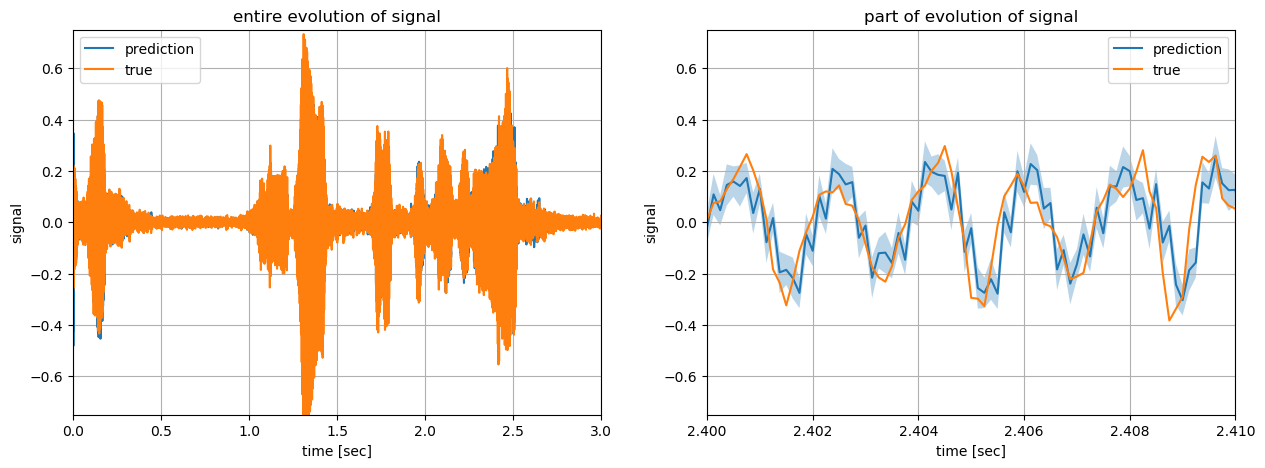

In [17]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, Œº_x_pred, label="prediction"), ax[2].plot(t, Œº_x_pred, label="prediction")
ax[2].fill_between(t, Œº_x_pred .- sqrt.(var_x_pred), Œº_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.4, 2.41), ax[2].set_ylim(-0.75,0.75), ax[1].set_ylim(-0.75, 0.75)

audioplayers(x_time, Œº_x_pred, fs=fs_desired)
;

## Visualize parameters

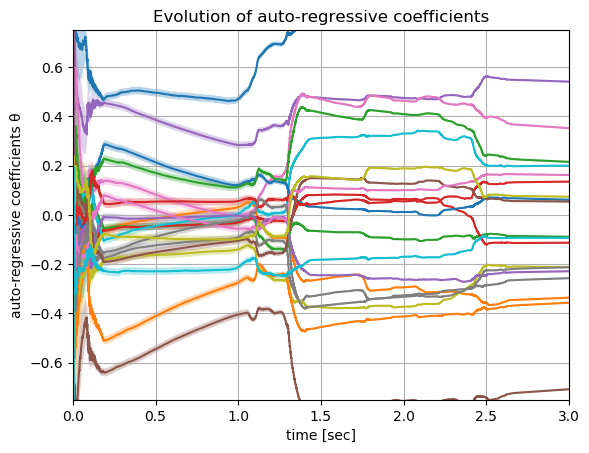

In [10]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t[1:stepsize:end], [Œº_Œ∏_mem[k][ki] for k=1:stepsize:length(Œº_Œ∏_mem)])
    
    plt.fill_between(t[1:stepsize:end], [Œº_Œ∏_mem[k][ki] for k=1:stepsize:length(Œº_Œ∏_mem)] .- sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:stepsize:length(Œº_Œ∏_mem)]), [Œº_Œ∏_mem[k][ki] for k=1:stepsize:length(Œº_Œ∏_mem)] .+ sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:stepsize:length(Œº_Œ∏_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients Œ∏"), plt.title("Evolution of auto-regressive coefficients")
;

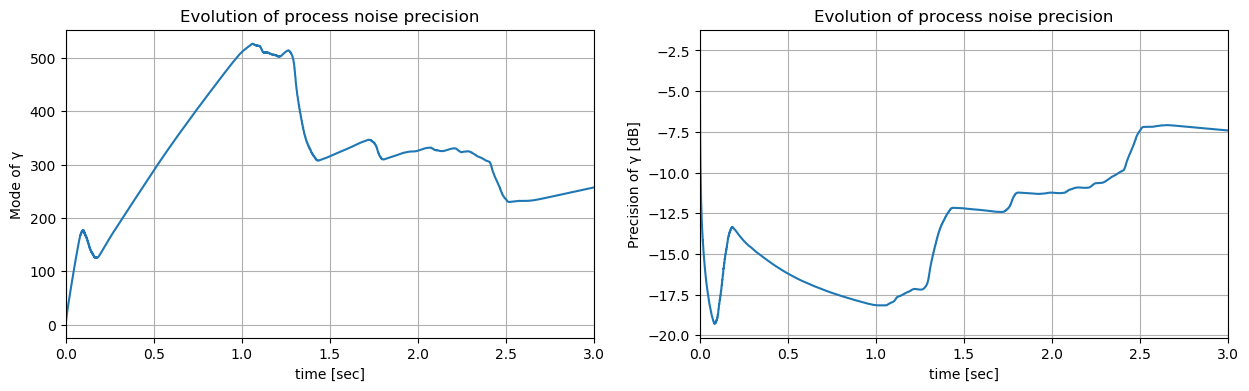

In [11]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t[1:stepsize:end], [(a_Œ≥_mem[k]-1)/b_Œ≥_mem[k] for k = 1:stepsize:length(a_Œ≥_mem)])
ax[2].plot(t[1:stepsize:end], [10*log10.(b_Œ≥_mem[k]^2/a_Œ≥_mem[k]) for k = 1:stepsize:length(a_Œ≥_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of Œ≥"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of Œ≥ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [12]:
using Distributions
include("visualization.jl")
;

In [13]:
Œº_Œ∏_cur = Œº_Œ∏_mem[end]
Œõ_Œ∏_cur = Œõ_Œ∏_mem[end]
a_Œ≥_cur = a_Œ≥_mem[end]
b_Œ≥_cur = b_Œ≥_mem[end]

Œ∏, Œ≥ = AR_distributions(Œº_Œ∏_cur, Œõ_Œ∏_cur, a_Œ≥_cur, b_Œ≥_cur)
mean_psd, std_psd = summary_psd(Œ∏, Œ≥)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency Œ∏ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency Œ∏ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;

UndefRefError: UndefRefError: access to undefined reference